In [1]:
import paths
import yaml
import os
import copy
import h5py
import GPy
import numpy as np
import numpy.random as npr
import scipy.optimize as spo
import scipy.linalg as spl
from matplotlib import pyplot as plt, collections as mc, patches as mpatches, cm, ticker, colors
from cklemap.sdfs.geom_mrst import GeomMRST
from cklemap.sdfs.bc_mrst import BCMRST
from cklemap.sdfs.tpfa import TPFA
from time import perf_counter
import cklemap.ckli.ckliest_h1reg as ckliest
from cklemap.sdfs.darcy import DarcyExp
from cklemap.sdfs.dasa import DASAExpLM, DASAExpLMAMPS
import cklemap.ckli.mapest as mapest

In [2]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None, cb=False):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    if cb:
        fig.colorbar(p, ax=ax)
    return p

In [3]:
amps = True
res_fac = 1
resolution = '1x'
resolution_iYobs = '4x'
num_trials = 1
seed = 0
#Nuobs = 50
NYobs = 100
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
Nuxi = 1000
Nens = 5000
beta_ckli = 1e1
Ygamma_ckli = 1e-4
ugamma_ckli = 1e-4
gamma_map = 1e-6
std_dev_ref = 1.0
cor_len_ref = 0.1
Neumann_sd = 0
lsq_method = 'trf'
run_PICKLE = True
data_path = '../data/'
results_path = '../results/'
figures_path = '../figures/'
geom_filename = data_path + f'geom/geom_{resolution}.mat'
geom_fine_filename = data_path + f'geom/geom_{resolution_iYobs}.mat'
bc_filename = data_path + f'bc/bc_{resolution}.mat'
conduct_filename = data_path + f'yref/conduct_log_RF1_{resolution}.mat'
well_cells_filename = data_path + f'well_cells/well_cells_{resolution}.mat'
yobs_filename = data_path + f'yobs/yobs_{NYobs}_{resolution_iYobs}.npy'
ref = "Yref=RF1"

In [4]:
Yfac = 7.0 # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)

with h5py.File(conduct_filename, 'r') as f:
    Yref = f.get('conduct_log')[:].ravel() - Yfac

In [5]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]

In [6]:
# Observations
rs = npr.RandomState(seed)
Nc = geom.cells.num
Ninf = geom.faces.num_interior

# u observations
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1

prob = DarcyExp(TPFA(geom, bc), iuobs, amps)
uref = prob.solve(Yref)
uobs = uref[iuobs]
Nuobs = iuobs.size

In [7]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref + Yfac, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [8]:
if os.path.exists(yobs_filename):
    print(f"iYobs read from file {yobs_filename}")
    iYobs_fine = np.load(yobs_filename)
    print(iYobs_fine.shape)
    geom_fine = GeomMRST(geom_fine_filename)
    iYobs = np.array([geom.cellsContain(geom_fine.cells.centroids.T[iYobs_fine[t]]) for t in range(num_trials)])
else:
    print(f"iYobs set randomly generated and saved to {yobs_filename}")
    iYobs = np.array([np.sort(rs.choice(Nc, NYobs, replace=False)) for _ in range(num_trials)])
    np.save(yobs_filename, iYobs)
print(f"{iYobs.shape=}")
print(iYobs)

iYobs read from file ../data/yobs/yobs_100_4x.npy
(10, 100)
iYobs.shape=(1, 100)
[[   4   14   31   34   52   53   54   82   89  122  141  142  148  152
   187  191  192  218  231  254  260  278  302  315  322  326  333  342
   347  361  362  364  376  408  420  427  431  434  438  446  458  465
   481  483  487  529  535  536  554  558  587  597  620  651  667  674
   737  758  761  838  847  853  857  863  884  897  900  930  942  961
  1001 1003 1030 1031 1054 1061 1069 1081 1095 1114 1122 1126 1131 1157
  1164 1175 1178 1187 1239 1270 1280 1285 1305 1338 1347 1352 1402 1438
  1444 1465]]


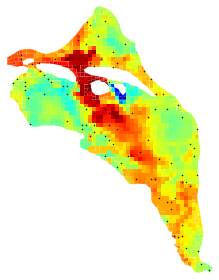

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_patch(patches, Yref + Yfac, fig, ax, geom.cells.centroids[:, iYobs[0]], 'Yref', 0, 12)
fig.tight_layout()
fig.savefig(figures_path + f'Yref/Yref_NY={NYobs}_1x_from_4x.pdf', dpi=300)

In [10]:
exp = f'NY={NYobs}_Nu={iuobs.size}_{NYlearn=}_gamma={gamma_map}_{lsq_method=}_h1reg_{amps=}_{ref}'
print(exp)

timings = np.zeros((num_trials, 6))
nfevs = np.zeros((num_trials, 3), dtype=int)
rel_errors = np.zeros((num_trials, 4))
abs_errors = np.zeros((num_trials, 4))
solve_time = np.zeros((num_trials))
obj_time = np.zeros((num_trials))
jac_time = np.zeros((num_trials))

Yobs = np.zeros((num_trials, NYobs))
Ypred = np.zeros((num_trials, Nc))
CYpred = np.zeros((num_trials, Nc, Nc))
umean = np.zeros((num_trials, Nc))
Cu = np.zeros((num_trials, Nc, Nc))
upred = np.zeros((num_trials, Nc))
Cupred = np.zeros((num_trials, Nc, Nc))

PsiY = np.zeros((num_trials, Nc, NYxi))
LambdaY = np.zeros((num_trials, NYxi))
Psiu = np.zeros((num_trials, Nc, Nuxi))
Lambdau = np.zeros((num_trials, Nuxi))

uxi = np.zeros((num_trials, Nuxi))
Yxi = np.zeros((num_trials, NYxi))
uest = np.zeros((num_trials, Nc))
Yest = np.zeros((num_trials, Nc))
Yest_MAPH1 = np.zeros((num_trials, Nc))
if Neumann_sd != 0:
    Nq = np.count_nonzero(bc.kind == 'N')
    q_MAPH1 = np.zeros((num_trials, Nq))

NY=100_Nu=323_NYlearn=100_gamma=1e-06_lsq_method='trf'_h1reg_amps=True_Yref=RF1


In [11]:
for t in range(num_trials):
    iYlearn = iYobs[t]
    Ylearn = Yref[iYlearn]
    Yobs[t] = Yref[iYobs[t]]

    ts = perf_counter()
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom.cells.centroids[:, iYlearn].T, Ylearn[:, None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    print(f'{klearn.lengthscale.values[0]}')

    mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs[t]].T, Yobs[t, :, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Ypred[t], CYpred[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
    timings[t, 0] = perf_counter() - ts

print(f"GPR: {timings[:, 0]} s")

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s03  0006   1.899926e+02   1.109159e+03 
    00s06  0012   1.684233e+02   1.873149e+00 
    00s09  0016   1.683999e+02   7.452364e-08 
    00s09  0017   1.683999e+02   7.452364e-08 
Runtime:     00s09
Optimization status: Converged

0.03511207825411311
GPR: [0.41182513] s


In [12]:
if run_PICKLE:
    for t in range(num_trials):
        ts = perf_counter()
        umean[t], Cu[t] = ckliest.smc_gp(Ypred[t], CYpred[t], Nens, prob, rs, randomize_bc=True, randomize_scale=Neumann_sd)
        upred[t], Cupred[t] = ckliest.gpr(umean[t], Cu[t], uobs, iuobs)
        timings[t, 1] = perf_counter() - ts

    print(f"Monte Carlo: {timings[:, 1]} s")

Monte Carlo: [14.69052116] s


In [13]:
if run_PICKLE:
    Ym = Ypred
    CYm = CYpred
    um = umean #or change to upred
    Cum = Cu #or change to Cupred

    rel_errors[:, 0] = np.array([rl2e(Ym[t], Yref) for t in range(num_trials)])
    abs_errors[:, 0] = np.array([infe(Ym[t], Yref) for t in range(num_trials)])

    print(f"GPR\tRelative error: {rel_errors[:, 0]}")
    print(f"GPR\tInfinity error: {abs_errors[:, 0]}")

GPR	Relative error: [0.12574837]
GPR	Infinity error: [4.49993274]


In [14]:
if run_PICKLE:
    for t in range(num_trials):
        ts = perf_counter()
        PsiY[t], LambdaY[t] = ckliest.KL_via_eigh(CYm[t], NYxi)
        Psiu[t], Lambdau[t] = ckliest.KL_via_eigh(Cum[t], Nuxi)
        timings[t, 2] = perf_counter() - ts

    print(f"eigendecomposition: {timings[:, 2]} s")

eigendecomposition: [3.19349676] s


In [15]:
# PICKLE estimate
ssv = None if Neumann_sd == 0 else np.delete(np.arange(Nc), np.unique(geom.cells.to_hf[2*geom.faces.num_interior:][bc.kind == 'N']))
Lreg = mapest.compute_Lreg(geom)

if run_PICKLE:
    for t in range(num_trials):
        res = ckliest.LeastSqRes(NYxi, Ym[t], PsiY[t], Nuxi, um[t], Psiu[t], prob, ugamma_ckli, Ygamma_ckli, res_fac, Lreg, iuobs, uobs, iYobs[t], Yobs[t], beta_ckli, ssv=ssv)

        ts = perf_counter()
        sol = spo.least_squares(res.val, np.zeros(Nuxi + NYxi), jac=res.jac, method=lsq_method, verbose=2)
        ckli_status = sol.status
        timings[t, 3] = perf_counter() - ts
        nfevs[t, 0] = sol.nfev
        print(f'CKLI optimality: {sol.optimality : g}')

        uxi[t] = sol.x[:Nuxi]
        Yxi[t] = sol.x[Nuxi:]
        uest[t] = um[t] + Psiu[t] @ uxi[t]
        Yest[t] = Ym[t] + PsiY[t] @ Yxi[t]

    rel_errors[:, 1] = np.array([rl2e(Yest[t], Yref) for t in range(num_trials)])
    abs_errors[:, 1] = np.array([infe(Yest[t], Yref) for t in range(num_trials)])

    print(f"PICKLE: {timings[:, 3]} s")
    print(f"PICKLE\trelative L2 error: {rel_errors[:, 1]}")
    print(f"PICKLE\tabsolute infinity error: {abs_errors[:, 1]}")

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4122e+03                                    1.98e+03    
       1              2         9.0270e+02      1.51e+03       1.00e+00       8.02e+02    
       2              3         1.8742e+02      7.15e+02       2.00e+00       3.94e+01    
       3              4         9.3458e+01      9.40e+01       4.00e+00       2.87e+01    
       4              5         9.3222e+01      2.36e-01       4.00e+00       3.64e+01    
       5              6         7.0322e+01      2.29e+01       1.00e+00       2.16e+01    
       6              7         6.6665e+01      3.66e+00       1.00e+00       1.44e+01    
       7              8         6.5565e+01      1.10e+00       2.50e-01       1.17e+01    
       8              9         6.5431e+01      1.34e-01       6.25e-02       1.09e+01    
       9             10         6.5408e+01      2.28e-02       1.56e-02       1.08e+01    

In [16]:
Lreg = mapest.compute_Lreg(geom)
for t in range(num_trials):
    # MAP H1 estimate
    loss = mapest.LossVec(Nc, Nc, iuobs, uobs, iYobs[t], Yobs[t], gamma_map, Lreg) # H1 regularization
    if amps:
        prob.setup_amps(iuobs)
        dasa = DASAExpLMAMPS(prob.partial_solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u, prob.residual_sens_Y, prob.u_sens_p, (Nuobs + NYobs + Ninf, Nc), Nuobs)
    else:
        dasa = DASAExpLM(prob.solve, loss.val, loss.grad_u, loss.grad_Y, prob.residual_sens_u, prob.residual_sens_Y, (Nuobs + NYobs + Ninf, Nc), Nuobs)
    ts = perf_counter()
    sol = spo.least_squares(dasa.obj, np.zeros(Nc), jac=dasa.grad, method=lsq_method, verbose=2)
    timings[t, 4] = perf_counter() - ts
    Yest_MAPH1[t] = sol.x
    nfevs[t, 1] = sol.nfev

    MAP_status = sol.status
    print(f'MAP status: {MAP_status}, message: {sol.message}')
    
    solve_time[t] = dasa.solve_time
    obj_time[t] = dasa.obj_time
    jac_time[t] = dasa.jac_time

rel_errors[:, 2] = np.array([rl2e(Yest_MAPH1[t], Yref) for t in range(num_trials)])
abs_errors[:, 2] = np.array([infe(Yest_MAPH1[t], Yref) for t in range(num_trials)])

print(f"MAP: {timings[:, 4]} s")
print(f"MAP\trelative L2 error: {rel_errors[:, 2]}")
print(f"MAP\tabsolute infinity error: {abs_errors[:, 2]}")
print(f"MAP solve time: {solve_time}")
print(f"MAP objective time: {obj_time}")
print(f"MAP Jacobian time: {jac_time}")

adj size = (323, 1475), nnz = 476425
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.5711e+02                                    5.84e+01    
adj size = (323, 1475), nnz = 476425
       1              2         6.4755e+02      1.10e+02       1.00e+00       4.94e+01    
adj size = (323, 1475), nnz = 476425
       2              3         4.6739e+02      1.80e+02       2.00e+00       2.92e+01    
adj size = (323, 1475), nnz = 476425
       3              4         2.6106e+02      2.06e+02       4.00e+00       7.45e+00    
adj size = (323, 1475), nnz = 476425
       4              5         1.0646e+02      1.55e+02       8.00e+00       2.52e+00    
adj size = (323, 1475), nnz = 476425
       5              6         1.5315e+01      9.11e+01       1.60e+01       3.62e+00    
adj size = (323, 1475), nnz = 476425
       6              7         6.3548e+00      8.96e+00       3.20e+01       2.49e+00    
adj size = (3

In [17]:
np.savetxt(results_path + f'iYobs/iYobs_{exp}.txt', iYobs.astype(int), fmt='%i')
np.savetxt(results_path + f'timings/timings_{exp}.txt', timings)
np.savetxt(results_path + f'nfevs/nfevs_{exp}.txt', nfevs.astype(int), fmt='%i')
np.savetxt(results_path + f'rel_errors/rel_errors_{exp}.txt', rel_errors)
np.savetxt(results_path + f'abs_errors/abs_errors_{exp}.txt', abs_errors)
np.savetxt(results_path + f'YGPR/YGPR_{exp}.txt', Yref)
np.savetxt(results_path + f'YPICKLE/YPICKLE_{exp}.txt', Yest)
np.savetxt(results_path + f'YMAP/YMAP_{exp}.txt', Yest_MAPH1)

In [20]:
figures_path + exp

"../figures/NY=100_Nu=323_NYlearn=100_gamma=1e-06_lsq_method='trf'_h1reg_amps=True_Yref=RF1"

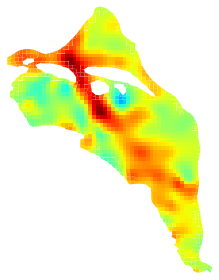

In [21]:
if run_PICKLE:
    fig, ax = plt.subplots(figsize=(4, 4))

    plot_patch(patches, Yest[0, :] + Yfac, fig, ax, None, 'Yest (PICKLE)', 0, 12)

    fig.tight_layout()
    fig.savefig(figures_path +
                f'YPICKLE/YPICKLE_{exp}.pdf', dpi=300, bbox_inches='tight')


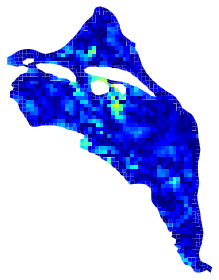

In [22]:
if run_PICKLE:
    fig, ax = plt.subplots(figsize=(4, 4))

    plot_patch(patches, np.abs(Yest[0, :] - Yref), fig, ax, None, 'Ydiff (PICKLE)', 0, 7)

    fig.tight_layout()
    fig.savefig(
        figures_path + f'Ydiff_PICKLE/Ydiff_PICKLE_{exp}.pdf', dpi=300, bbox_inches='tight')


In [20]:
t=0

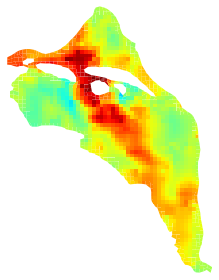

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))

plot_patch(patches, Yest_MAPH1[t, :] + Yfac, fig, ax, None, 'Yest (MAP)', 0, 12)

fig.tight_layout()
fig.savefig(figures_path +
            f'YMAP/YMAP_{exp}.pdf', dpi=300, bbox_inches='tight')


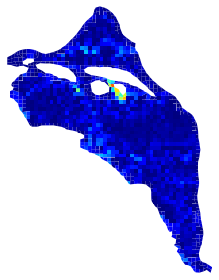

In [25]:
fig, ax = plt.subplots(figsize=(4, 4))

plot_patch(patches, np.abs(Yest_MAPH1[t, :] - Yref), fig, ax, None, 'Ydiff (MAP)', 0, 7)

fig.tight_layout()
fig.savefig(figures_path +
            f'Ydiff_MAP/Ydiff_MAP_{exp}.pdf', dpi=300, bbox_inches='tight')
